# Prioritize hypotheses, launch an A/B test, and analyze the results

An unknown online store wants to know which hypotheses will help boost revenue for the store. Prioritize the hypotheses, launch an A/B test, and analyze the results.

# Step 1

Download the data, preprocess the data

In [1]:
#import pandas and other important libraries
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [2]:
#read all input data and assign each dataset to a variable
try:
    hypotheses = pd.read_csv('hypotheses_us.csv', sep=';')
except:
    hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
    
try:
    orders = pd.read_csv('orders_us.csv', parse_dates=['date'])
except:
    orders = pd.read_csv('/datasets/orders_us.csv', parse_dates=['date'])
    
try:
    visits = pd.read_csv('visits_us.csv', parse_dates=['date'])
except:
    visits = pd.read_csv('/datasets/visits_us.csv', parse_dates=['date'])

In [3]:
hypotheses.info()
pd.set_option('max_colwidth', 120)
hypotheses

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Effort        9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8
4,Change the background color on the main page. This will increase user engagement,3,1,1,1
5,Add a customer review page. This will increase the number of orders,3,2,2,3
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5


In [4]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.info()
print('\nNumber of duplicates found: ', orders.duplicated().sum())
print('\nNumber of missing values found: ')
print(orders.isna().sum())
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null float64
group             1197 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB

Number of duplicates found:  0

Number of missing values found: 
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A
1195,1947021204,1614305549,2019-08-14,5.5,A


In [5]:
print('number of buyers in group A before the change:', orders.query('group=="A"')['visitor_id'].count())
print('number of buyers in group B before the change:', orders.query('group=="B"')['visitor_id'].count())

group_A = orders['visitor_id'].values[np.where(orders['group'].values == 'A')]
group_B = orders['visitor_id'].values[np.where(orders['group'].values == 'B')]
AB_id = np.intersect1d(group_B,group_A, return_indices=True)

orders = orders.loc[np.invert(np.isin(orders['visitor_id'].values, AB_id))]
print('\nnumber of buyers in group A after the change:', orders.query('group=="A"')['visitor_id'].count())
print('number of buyers in group B after the change:', orders.query('group=="B"')['visitor_id'].count())
orders

number of buyers in group A before the change: 557
number of buyers in group B before the change: 640

number of buyers in group A after the change: 468
number of buyers in group B after the change: 548


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B
...,...,...,...,...,...
1191,3592955527,608641596,2019-08-14,255.7,B
1192,2662137336,3733762160,2019-08-14,100.8,B
1193,2203539145,370388673,2019-08-14,50.1,A
1194,1807773912,573423106,2019-08-14,165.3,A


In [6]:
visits.info()
print('\nNumber of duplicates found: ', visits.duplicated().sum())
print('\nNumber of missing values found: ')
print(visits.isna().sum())
visits

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date      62 non-null datetime64[ns]
group     62 non-null object
visits    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB

Number of duplicates found:  0

Number of missing values found: 
date      0
group     0
visits    0
dtype: int64


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


# Step 2

The file hypotheses_us.csv contains nine hypotheses on boosting an online store's revenue with Reach, Impact, Confidence, and Effort specified for each.

The task is to:

- Apply the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Apply the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
- Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

In [7]:
# Calculating ICE and rounding by 2
hypotheses['ICE'] = ((hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']).round(2)

hypotheses[['Hypothesis', 'ICE']].sort_values('ICE', ascending=False)

,Hypothesis,ICE
8,Launch a promotion that gives users discounts on their birthdays,16.20
0,Add two new channels for attracting traffic. This will bring 30% more users,13.33
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.20
6,Show banners with current offers and sales on the main page. This will boost conversion,8.00
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.00
1,Launch your own delivery service. This will shorten delivery time,2.00
5,Add a customer review page. This will increase the number of orders,1.33
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.12
4,Change the background color on the main page. This will increase user engagement,1.00


In terms of ICE, 8, 0, 6, and 7 gave the most promising hypotheses. 

In [8]:
# Calculating RICE
hypotheses['RICE'] = (hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence']) / hypotheses['Effort']

hypotheses[['Hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,Hypothesis,RICE
7,Add a subscription form to all the main pages. This will help you compile a mailing list,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,40.0
8,Launch a promotion that gives users discounts on their birthdays,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,9.0
1,Launch your own delivery service. This will shorten delivery time,4.0
5,Add a customer review page. This will increase the number of orders,4.0
4,Change the background color on the main page. This will increase user engagement,3.0


In terms of RICE, 7, 2, 0, and 6 gave the most promising hypotheses. Except this time, 7 is in first place, due to the Reach being 10 while the other values have lower. 8 for instance has 1 reach, making it not even having enough to be in the top 4.

In [9]:
hypotheses

,Hypothesis,Reach,Impact,Confidence,Effort,ICE,RICE
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.33,40.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.00,4.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.00,56.0
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.12,9.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.00,3.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.33,4.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.00,40.0
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.20,112.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.20,16.2


# Conclusion

In terms of both RICE and ICE, hypotheses 7, 2, 0, 6, and 8 gave the most promising hypotheses. 7 being in first place for RICE, and 8 being first place in ICE.

# Step 3

You carried out an A/B test and got the results described in the files orders_us.csv and visits_us.csv.

Analyze the A/B test:
- Graph cumulative revenue by group. Make conclusions and conjectures.
- Graph cumulative average order size by group. Make conclusions and conjectures.
- Graph the relative difference in cumulative average order size for group B compared with group A. Make conclusions and -conjectures.
- Calculate each group's conversion rate as the ratio of orders to the number of visits for each day. Plot the daily conversion rates of the two groups and describe the difference. Draw conclusions and make conjectures.
- Plot a scatter chart of the number of orders per user. Make conclusions and conjectures.
- Calculate the 95th and 99th percentiles for the number of orders per user. Define the point at which a data point becomes an anomaly.
- Plot a scatter chart of order prices. Make conclusions and conjectures.
- Calculate the 95th and 99th percentiles of order prices. Define the point at which a data point becomes an anomaly.
- Find the statistical significance of the difference in conversion between the groups using the raw data. Make conclusions and conjectures.
- Find the statistical significance of the difference in average order size between the groups using the raw data. Make conclusions and conjectures.
- Find the statistical significance of the difference in conversion between the groups using the filtered data. Make conclusions and conjectures.
- Find the statistical significance of the difference in average order size between the groups using the filtered data. Make conclusions and conjectures.
- Make a decision based on the test results. The possible decisions are: 1. Stop the test, consider one of the groups the leader. 2. Stop the test, conclude that there is no difference between the groups. 3. Continue the test.

## Graph cumulative revenue by group

In [10]:
# building an array with unique paired date-group values 
datesGroups = orders[['date', 'group']].drop_duplicates()

# getting aggregated cumulative daily data on orders 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# getting aggregated cumulative daily data on visitors 
visitsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

# merging the two tables into one and giving its columns descriptive names
cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


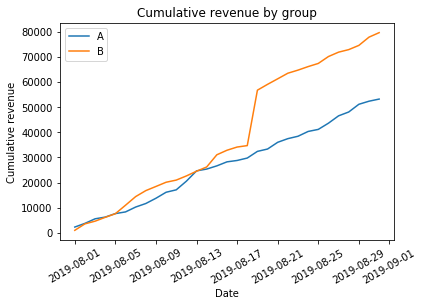

In [11]:
# DataFrame with cumulative orders and cumulative revenue by day, group A and group B
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Plotting the group A and B revenue graph 
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation = 30)
plt.title('Cumulative revenue by group')
plt.xlabel('Date')
plt.ylabel('Cumulative revenue')

plt.legend() 

### Conclusion
Group B and A are very similar for the first few days, when suddenly Group B takes the lead out of nowhere in 2019-08-17. This could be due to abnormally big orders.

## Graph cumulative average order size by group

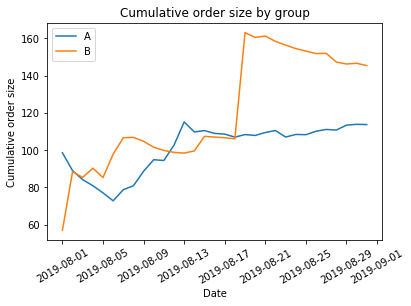

In [12]:
# Plotting the group A and B order size
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation = 30)
plt.title('Cumulative order size by group')
plt.xlabel('Date')
plt.ylabel('Cumulative order size')

plt.legend()

### Conclusion
The cumulative value is still fluctuating, with a big spike on 2019-08-17. Need to fix later

## Graph the relative difference

Text(0.5, 0, 'Date')

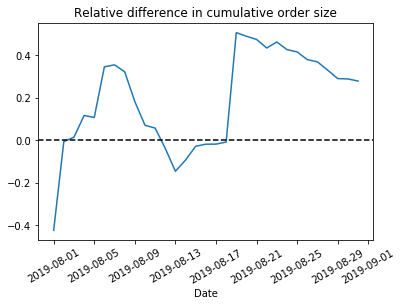

In [13]:
# gathering the data into one DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# plotting a relative difference graph for the average purchase sizes
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# adding the X axis
plt.axhline(y=0, color='black', linestyle='--')

# making it look neat
plt.xticks(rotation = 30)
plt.title('Relative difference in cumulative order size')
plt.xlabel('Date')
#plt.ylabel('Percentage relative difference')

### Conclusion
There are a lot of sudden changes, could definitely be due to large purchase sizes. What's notable here is that there is a big drop near 2019-08-07, and the same huge spike can still be seen in 2019-08-17

## Calculate each group's conversion rate

Text(0.5, 0, 'Date')

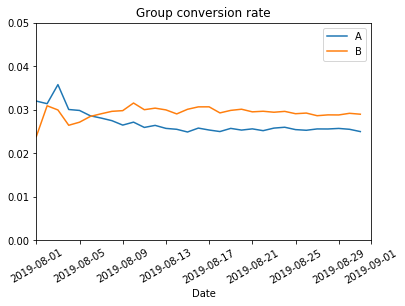

In [14]:
# calculating cumulative conversion
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# selecting data on group A 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# selecting data on group B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# plotting the graphs
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

# setting the axes' scale
plt.axis(["2019-08-01", '2019-09-01', 0, 0.05])

# making it look neat
plt.xticks(rotation = 30)
plt.title('Group conversion rate')
plt.xlabel('Date')
#plt.ylabel('Percentage conversion rate')

### Conclusion
At the start of the test, A had the lead and spiked a little bit on 2019-08-03. After that day, A dipped and B gradually gained and stabilized at an almost steady value

## Plot a scatter chart of number of orders per user

In [15]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))

ordersByUsers.columns = ['visitor_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Text(0, 0.5, 'Orders')

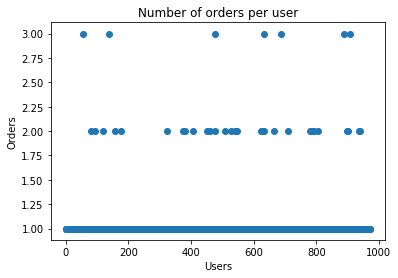

In [16]:
# the range of numbers from 0 to the number of observations in ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 

# making it look neat
plt.title('Number of orders per user')
plt.xlabel('Users')
plt.ylabel('Orders')

### Conclusion
From the looks of it, most users ordered either 2 or 3, while there are some outliers where people purchased 11. Those cases could be anomalies.

## Calculate the 95th and 99th percentiles for the number of orders per user

In [17]:
print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))
np.percentile(ordersByUsers['orders'], [95, 99])

     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


array([1., 2.])

### Conclusion
Not more than 5% of the users placed more than two orders, and not more than 1% of users made more than four. 

## Plot a scatter chart of order prices


      transaction_id  visitor_id       date  revenue group
425        590470918  1920142716 2019-08-19  19920.4     B
1196      3936777065  2108080724 2019-08-15   3120.1     B
1136       666610489  1307669133 2019-08-13   1425.8     A
744       3668308183   888512513 2019-08-27   1335.6     B
743       3603576309  4133034833 2019-08-09   1050.0     A
1103      1348774318  1164614297 2019-08-12   1025.8     A
1099       316924019   148427295 2019-08-12   1015.9     A
949       1347999392   887908475 2019-08-21    930.0     A
940       2420050534  4003628586 2019-08-08    905.8     B
613       4071177889  3931967268 2019-08-07    830.3     B


Text(0, 0.5, 'Revenue')

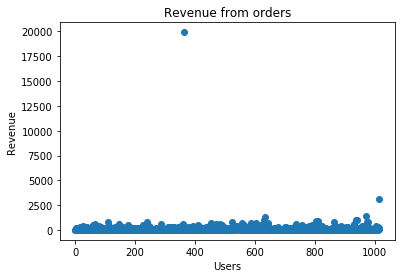

In [18]:
print(orders.sort_values(by='revenue',ascending=False).head(10))

x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'])

# making it look neat
plt.title('Revenue from orders')
plt.xlabel('Users')
plt.ylabel('Revenue')

### Conclusion
As seen on the scatter plot, most of the orders are below 2,500. There are two notable outliers, one near 3000, and the other at a staggering 20,000.  

## Calculate the 95th and 99th percentile of order prices

In [19]:
print(orders.head(10))
np.percentile(orders['revenue'], [95, 99])

    transaction_id  visitor_id       date  revenue group
0       3667963787  3312258926 2019-08-15     30.4     B
1       2804400009  3642806036 2019-08-15     15.2     B
3       3797467345  1196621759 2019-08-15    155.1     B
4       2282983706  2322279887 2019-08-15     40.5     B
5        182168103   935554773 2019-08-15     35.0     B
6        398296753  2900797465 2019-08-15     30.6     B
7       2626614568    78758296 2019-08-15     20.1     A
8       1576988021   295230930 2019-08-15    215.9     A
9       1506739906  1882260405 2019-08-15     30.5     B
10      3649131742   879864040 2019-08-15     65.7     A


array([414.275, 830.3  ])

### Conclusion
Not more than 5% of the orders placed cost more than 435.54, and not more than 1% of orders placed cost more than 900.90.

## Find the statistical significance of the difference in conversion between the groups using the raw data

In [20]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Relative conversion gain for group B compared with group A: {0:.3f}'.format(sampleB.mean()/sampleA.mean()-1)) 

p-value: 0.00551
Relative conversion gain for group B compared with group A: 0.160


### Conclusion
The p-value is lower than 0.05, so we reject the null hypotheses that there's NOT a statstically significant difference in conversion between the groups. The relative conversion gain for group B compared with group A is 13.8%

##  Find the statistical significance of the difference in average order size between the groups using the raw data

In [21]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Relative difference between the group average order size: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.431
Relative difference between the group average order size: 0.278


### Conclusion

The p-value is greater than 0.05, so there are no statistically significant differences between the groups' average order sizes. The relative difference between the group average order size is 25.2%.

## Find the statistical significance of the difference in conversion between the groups using the filtered data

In [22]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 3]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 3]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 500]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

print(abnormalUsers.head())
print(abnormalUsers.shape)

1099    148427295
928     204675465
684     358944393
648     382846391
751     689129267
Name: visitor_id, dtype: int64
(37,)


#### Explanation for my numbers
The main goal of the above code block was to remove anomalies from the data. From the data we got from the 95th and 99th percentiles, the average order size were 435.54 and 900.90. For number of users, the 95th and 99th percentiles were two orders and four orders.

I decided that I would consider anomalous users those who made four or more orders or placed one for more than 500. With this, i'll be removing 1% of users with the most orders and between 1% and 5% of the most expensive orders.

From the block of code, we now know that there are 50 anomalous users in total.

With this, the data is now considered "filtered"

In [23]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

print('p-value: {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Relative conversion gain for group B compared with group A: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.00516
Relative conversion gain for group B compared with group A: 0.167


### Conclusion

The results for conversion didn't change much, we've reached the significance level. Group B is much better than group A

## Find the statistical significance of the difference in average order size between the groups using the filtered data

In [24]:
print('p-value: {0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print('Relative difference between the group average order size: {0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value: 0.496
Relative difference between the group average order size: -0.006


### Conclusion
The results showed that p-value has increased, but now the difference between the segments is 1.3% instead of 25.2% which is a huge difference.

## Make a decision based on the test results

Based on the calculations of both RICE and ICE, hypotheses 7, 2, 0, 6, and 8 gave the most promising hypotheses. 7 being in first place for RICE, and 8 being first place in ICE.

Based on the test results, I think that we can stop the tests, as we have found Group B to be the clear winner. 

There's a statistically significant difference in conversion between the groups, according to both the raw and the filtered data.

The raw data didn't show a statistically significant difference between the groups in terms of average purchase size. However, after the anomalies were removed, it turned out there was a statistically significant difference.

The group conversion rate graph shows that group B's results are better than those of group A, and has a tendency to grow or have stabilized around the mean.

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

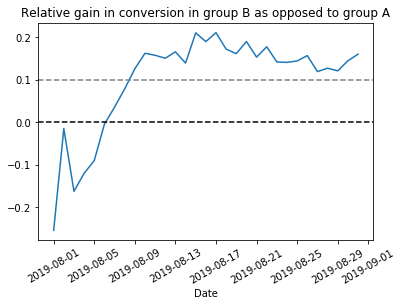

In [25]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Relative gain in conversion in group B as opposed to group A")

# making it look neat
plt.xticks(rotation = 30)
plt.title('Relative gain in conversion in group B as opposed to group A')
plt.xlabel('Date')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xticks(rotation = 30)

As we can see with the graph, Group B was a bit behind for the first few days, but suddenly taking the lead peaking near 20% higher than Group A.

Based on these facts, we can conclude taht the test should be stopped, and that Group B is the leader.